In [1]:
using StatsBase
using Distributions
using Plots
using Serialization

default(margin=6Plots.mm) # plot parameters

# Input parameters

const BURN_IN_GEN_N = 800
const TOTAL_GEN_N = 2200

# Max coordinates of the population bounding space
const X_MAX_BURN_IN = 5
const X_MAX = 500

const X_START = X_MAX_BURN_IN

# Dimensions of the whole space
const X_DIM = X_MAX

# Population parameters
#const INIT_PERSON_N = 30
const DEMES_FULL_AT_START = 5
const K_CAPACITY = 100
const R_PROLIF_RATE = 2
const r_LOG_PROLIF_RATE = log(2)

# Gene parameters
const LOCI_N = 20
const MUT_RATE = 0.1
const M_MIG_RATE = 0.05
const MUT_DELETER_RATE = 0.9
const S_SELECT_COEF = 0.03

0.03

In [2]:
const N_IN_BATCH = 10

meanfitnessfor_set = [deserialize("../output/1d_fortest/for_$i-meanf.dat") for i in 1:N_IN_BATCH]
meanfitnesswhile_set = [deserialize("../output/1d_fortest/while_$i-meanf.dat") for i in 1:N_IN_BATCH]

10-element Vector{Matrix{Float32}}:
 [1.0 0.99294996 … 4.7493194f10 4.8234693f10; 1.0 0.9937561 … 4.8355512f10 4.8335544f10; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]
 [1.0 0.9932777 … 1.3649217f10 1.3666621f10; 1.0 0.9947389 … 1.3703702f10 1.3975034f10; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]
 [1.0 0.99775165 … 2.1374888f10 2.1481144f10; 1.0 0.9966567 … 2.0526148f10 2.0741274f10; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]
 [1.0 0.9964445 … 4.0572695f10 4.0540393f10; 1.0 0.9938347 … 3.974791f10 4.0687497f10; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]
 [1.0 0.99553335 … 3.0550325f10 3.0677811f10; 1.0 0.99710405 … 3.1209875f10 3.143924f10; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]
 [1.0 0.9968136 … 6.4623067f10 6.457432f10; 1.0 0.99540544 … 6.705719f10 6.734881f10; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]
 [1.0 0.993721 … 1.760664f11 1.782835f11; 1.0 0.99716747 … 1.7599206f11 1.7938942f11; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]


In [3]:
function N_t(m,r,K,t)
    x_ = (m/2)*K*exp(r*t)
    if x_ >= K
        x_ =  K
    end
    return x_
end

function growth_T(m,r)
    return log(2/m)/r
end

function s_e(s,m,r)
    return s*(m/2)*growth_T(m,r)
end

function x0(s,m,r,K,t)
    x_ = exp(s*(growth_T(m,r)-t))
    x_ /= (exp(s*(growth_T(m,r)-t))+2*N_t(m,r,K,t)-1)
    return x_
end

function u_p_cubic(P,s,m,r,K)
    local myexp = exp(s*growth_T(m,r))
    
    return (3*myexp*(myexp-1)*P-K*m*((myexp-1)*P+1)^3+K*m)/(3*myexp*(myexp-1)-K*m*myexp^3+K*m)
end

h2(s,m,r,K) = sqrt(exp(-s*growth_T(m,r))*K*m) # A* in my PDF
h1(s,m,r) = expm1(s*growth_T(m,r)) # B in my PDF

function u_p(P,s,m,r,K)
    local myh1 = h1(s,m,r)
    local myh2 = h2(s,m,r,K)
    u_ = erf(myh1*myh2*P+myh2)-erf(myh2)
    u_ /= erf(myh1*myh2+myh2)-erf(myh2)
    return u_
end

function u_p_peischl(P,s,m,r,K)
    local mys_e = s_e(s,m,r)
    u_ = expm1(-4*mys_e*K_CAPACITY*P)
    u_ /= expm1(-4*mys_e*K_CAPACITY)
    return u_
end

#= function u_p_alt(P,s,m,r,K)
    myA = s*growth_T(m,r)
    myB = 2/K/m
    u_1 = (-1+0im)^myB * _₂F₁(1,myB,2+myB,1-exp(myA))
    u_ = u_1 / ((P-1+0im)^(1+myB) * exp(-myB*myA) * _₂F₁(myB,1+myB,2+myB,(exp(-myA)-1)*(P-1)) + u_1)
    return u_
end =#
function u_p_alt(P,s,m,r,K)
    myA = expm1(s*growth_T(m,r))
    myB = 2/K/m + 1
    u_ = ((myA*P+1)^myB - 1)/((myA+1)^myB - 1)
    return u_
end

u_p_alt (generic function with 1 method)

In [4]:
LOCI_N_THEORY = LOCI_N

function large_p(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p_peischl(x0(s,m,r,K,t),1,m,r,K)
    return P_
end
function large_p_test(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p_peischl(x0(s,m,r,K,t),s,m,r,K)
    return P_
end
function large_p_test2(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p(x0(s,m,r,K,t),1,m,r,K)
    return P_
end
function mu_effect(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end
function mu_effect_test(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end
function mu_effect_test2(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test2(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test2(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end

function large_p_2015(s,migr,r,K,mut)
    my_4seK = 4*s_e(s,migr,r)*K
    P_ = -mut*my_4seK/expm1(-my_4seK)
    return P_
end
function mu_effect_2015(t)
    mu_ = 2*S_SELECT_COEF*(1-MUT_DELETER_RATE)*large_p_2015(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,MUT_RATE)
    mu_ -= 2*S_SELECT_COEF*MUT_DELETER_RATE*large_p_2015(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,MUT_RATE)
    return mu_
end

mu_effect_2015 (generic function with 1 method)

In [5]:
using QuadGK

function find_mf_theory(start_mf;mu_func=mu_effect)
    my_T = growth_T(M_MIG_RATE,r_LOG_PROLIF_RATE)
    sim_inte_result = quadgk(mu_func,0,my_T)[1]/my_T

    mean_fitness_sim_result = Array{Float64}(undef,0)

    for t_i in 1:BURN_IN_GEN_N
        mean_fitness_sim_result = cat(mean_fitness_sim_result,0,dims=1)
    end

    mean_fitness_sim_result = cat(mean_fitness_sim_result,start_mf, dims=1)

    for t_i in (BURN_IN_GEN_N+2):TOTAL_GEN_N
        mean_fitness_sim_result = cat(mean_fitness_sim_result,mean_fitness_sim_result[t_i-1]*(1+sim_inte_result)^LOCI_N_THEORY, dims=1)
    end
    return mean_fitness_sim_result
end

find_mf_theory (generic function with 1 method)

In [6]:
function get_normalised_matrix_max(meanfit_array)
    normal_array = copy(meanfit_array)
    for j in 1:(TOTAL_GEN_N-BURN_IN_GEN_N)
        gen_max = maximum(meanfit_array[:,BURN_IN_GEN_N+j])
        normal_array[:,BURN_IN_GEN_N+j] /= gen_max
    end
    return normal_array
end

function get_normalised_matrix_onset_mean(meanfit_array)
    normal_array = copy(meanfit_array)
    
    sum = 0
    count = 0
    for u in meanfit_array[:,BURN_IN_GEN_N+1]
        if u > 0
            sum += u
            count += 1
        end
    end
    gen_max = sum/count

    normal_array[:,BURN_IN_GEN_N+1:end] /= gen_max
    return normal_array
end

function find_front(meanfit_array,gen_n=TOTAL_GEN_N)
    front_array = Array{Float32}(undef,0)
    for j in 1:gen_n
        frontier = X_MAX
        while frontier != 1 && meanfit_array[frontier,j] < 0
            frontier -= 1
        end
        sum_total = meanfit_array[frontier,j]
        front_array = cat(front_array,sum_total, dims=1)
    end
    return front_array
end

function normalise_front_by_onset_mean(average_1d_array)
    normal_array = copy(average_1d_array)
    normal_array[BURN_IN_GEN_N+1:end] /= average_1d_array[BURN_IN_GEN_N+1]
    return normal_array
end

normalise_front_by_onset_mean (generic function with 1 method)

In [7]:
mffor_front_set = [find_front(meanfitnessfor_set[i]) for i in 1:N_IN_BATCH]
mffor_front_matrix = reduce(hcat,mffor_front_set)'
mffor_front_average = [mean(mffor_front_matrix[:,i]) for i in 1:TOTAL_GEN_N]
mffor_front_average_then_norm2 = normalise_front_by_onset_mean(mffor_front_average)

mfwhile_front_set = [find_front(meanfitnesswhile_set[i]) for i in 1:N_IN_BATCH]
mfwhile_front_matrix = reduce(hcat,mfwhile_front_set)'
mfwhile_front_average = [mean(mfwhile_front_matrix[:,i]) for i in 1:TOTAL_GEN_N]
mfwhile_front_average_then_norm2 = normalise_front_by_onset_mean(mfwhile_front_average)

2200-element Vector{Float32}:
 1.0
 0.994804
 0.9906915
 0.9862026
 0.9825754
 0.9780556
 0.9755616
 0.9713125
 0.96731365
 0.9656844
 ⋮
 0.026596308
 0.026151264
 0.026721861
 0.027205352
 0.026416067
 0.026209373
 0.026048545
 0.026530279
 0.026900679

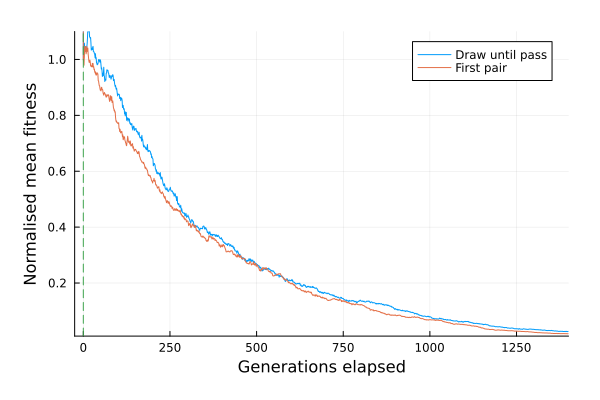

In [39]:
plot(-800:1399,mfwhile_front_average_then_norm2,label = "Draw until pass",xlims=(-25,TOTAL_GEN_N-BURN_IN_GEN_N),xlabel="Generations elapsed",ylabel="Norm. mean fitness",yrange=(0.01,1.1))
plot!(-800:1399,mffor_front_average_then_norm2,label = "First pair",xlims=(-25,TOTAL_GEN_N-BURN_IN_GEN_N),xlabel="Generations elapsed",ylabel="Normalised mean fitness",yrange=(0.01,1.1))
vline!([0],label=:none,style=:dash)

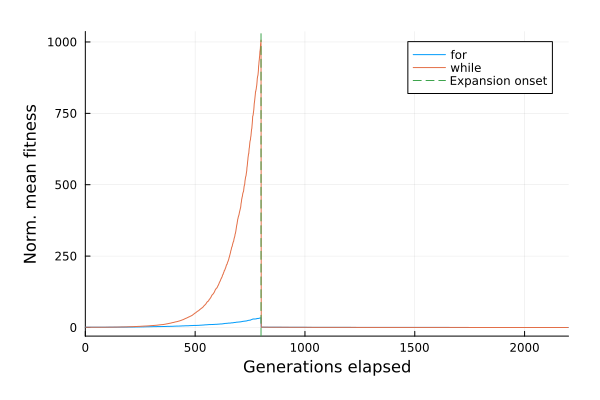

In [14]:
plot(mffor_front_average_then_norm2,label = "for",xlims=(0,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Norm. mean fitness")
plot!(mfwhile_front_average_then_norm2,label = "while",xlims=(0,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Norm. mean fitness")
vline!([BURN_IN_GEN_N],label="Expansion onset",style=:dash)

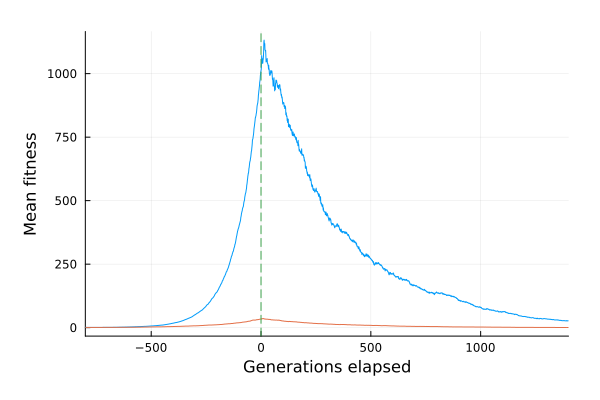

In [32]:
plot(-800:1399,mfwhile_front_average,label = "Draw until pass",xlims=(-BURN_IN_GEN_N,TOTAL_GEN_N-BURN_IN_GEN_N),xlabel="Generations elapsed",ylabel="Mean fitness")
plot!(-800:1399,mffor_front_average,label = "First pair",xlims=(-BURN_IN_GEN_N,TOTAL_GEN_N-BURN_IN_GEN_N),xlabel="Generations elapsed",ylabel="Mean fitness")
vline!([0],label=:none,legend=:none,style=:dash)

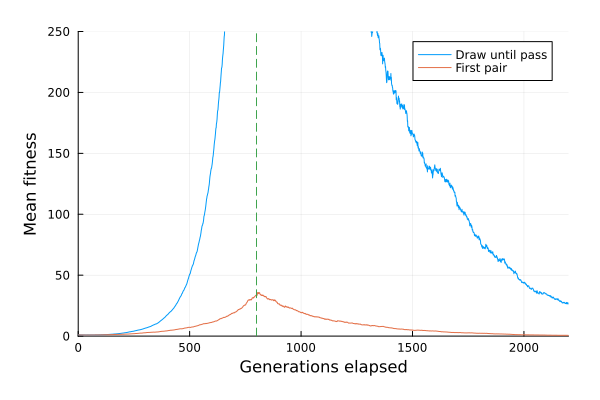

In [18]:
plot(mfwhile_front_average,label = "Draw until pass",xlims=(0,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Mean fitness")
plot!(mffor_front_average,label = "First pair",xlims=(0,TOTAL_GEN_N),ylims=(0,250),xlabel="Generations elapsed",ylabel="Mean fitness")
vline!([BURN_IN_GEN_N],label=:none,style=:dash)